In [1]:
# Import libraries 
import numpy as np
from plantcv import plantcv as pcv

In [2]:
class options:
    def __init__(self):
        self.image = "/Users/garethtate/plantcv/IMG_0781.JPG"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "multi_plant_workflow_results.json"
        self.outdir = "." # Store the output to the current directory 

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

# OPTIONAL: For debugging or for making figures 

# The image is relatively large, increase the global line thickness parameter 
pcv.params.line_thickness = 20

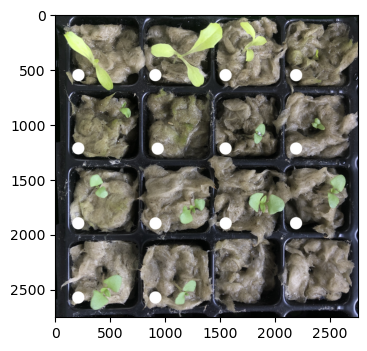

In [3]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

In [4]:
# Check if this is a night image, for some of these dataset's images were captured
# at night, even if nothing is visible. To make sure that images are not taken at
# night we check that the image isn't mostly dark (0=black, 255=white).
# if it is a night image it throws a fatal error and stops the workflow.

if np.average(img) < 50:
    pcv.fatal_error("Night Image")
else:
    print("Daylight Image")
    pass


Daylight Image


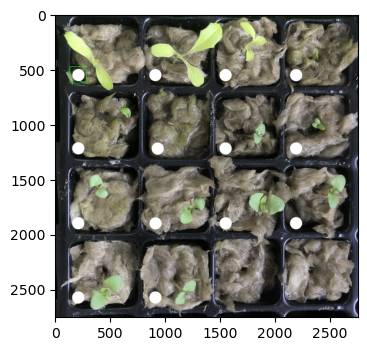

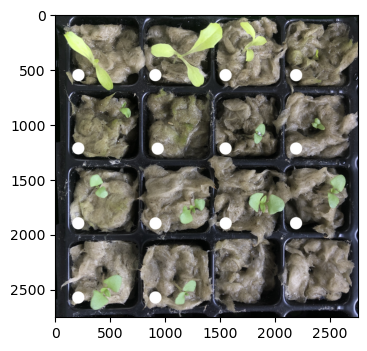

In [5]:
# Normalize the white color so you can later
# compare color between images.

# Inputs:
#   img = image object, RGB color space
#   roi = region for white reference, if none uses the whole image,
#         otherwise (x position, y position, box width, box height)

# white balance image based on white toughspot
img1 = pcv.white_balance(img, roi=(135,470,150,150))

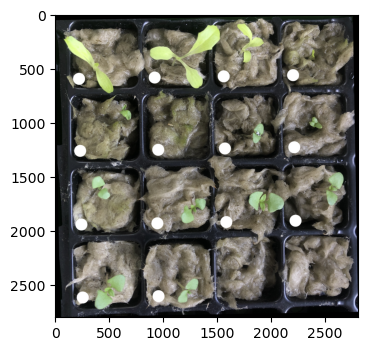

In [6]:
# Rotate the image slightly so the plants line up with 
# the grid that we'll add in a later step

# Inputs:
#   img = image object, RGB color space
#   rotation_deg = Rotation angle in degrees, can be negative, positive values 
#                  will move counter-clockwise 
#   crop = If True then image will be cropped to orginal image dimensions, if False
#          the image size will be adjusted to accommodate new image dimensions 
rotate_img = pcv.rotate(img=img1, rotation_deg=1, crop=False)

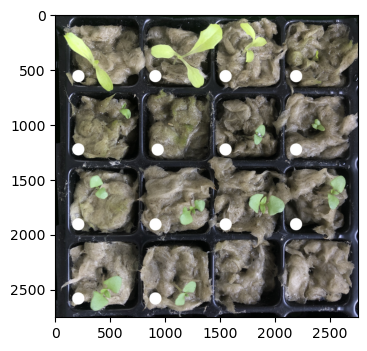

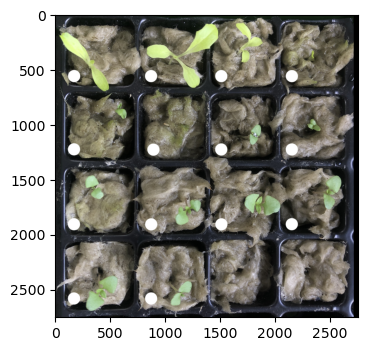

In [7]:
# Shift image. This step is important for clustering later on.
# For this image it also allows you to push the green raspberry pi camera
# out of the image. This step might not be necessary for all images.
# The resulting image is the same size as the original.

# Inputs:
#   img    = image object
#   number = integer, number of pixels to move image
#   side   = direction to move from "top", "bottom", "right","left"
shift1 = pcv.shift_img(img=img1, number=10, side='top')
img1 = shift1

shift1 = pcv.shift_img(img=img1, number=40, side='right')
img1 = shift1

In [8]:
# Optionally, one could use the `pcv.flip` function that flips an image in either the 
# horizontal or vertical direction

# Inputs:
#   img   = RGB or grayscale image data 
#   direction = The direction you want the image flipped, either 'horizontal' or 'vertical' 
#flipped_img = pcv.flip(img=img, direction='vertical')

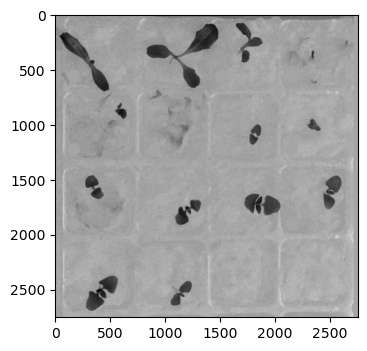

In [9]:
# Convert image from RGB color space to LAB color space
# Keep only the green-magenta channel (grayscale)

# Inputs:
#    rgb_img = image object, RGB color space
#    channel = color subchannel ('l' = lightness, 'a' = green-magenta , 'b' = blue-yellow)
a = pcv.rgb2gray_lab(rgb_img=img1, channel='a')

In [10]:
img.shape

(2752, 2758, 3)

In [11]:
img.max()

255

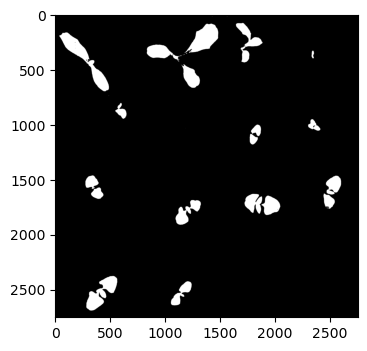

In [12]:
# Set a binary threshold on the saturation channel image

# Inputs:
#    gray_img    = img object, grayscale
#    threshold   = threshold value (0-255)
#    max_value   = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#       - If object is light then standard thresholding is done
#       - If object is dark then inverse thresholding is done
img_binary = pcv.threshold.binary(gray_img=a, threshold=114, max_value=255, object_type='dark')
#                                                        ^
#                                                        |
#                                         adjust this value

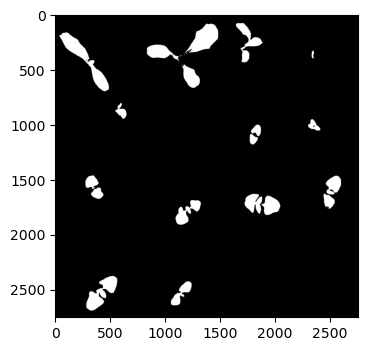

In [13]:
# Fill in small objects (speckles)

# Inputs:
#    bin_img  = binary image. img will be returned after filling
#    size     = minimum object area size in pixels (integer)
fill_image = pcv.fill(bin_img=img_binary, size=10)
#                                                ^
#                                                |
#                                 adjust this value

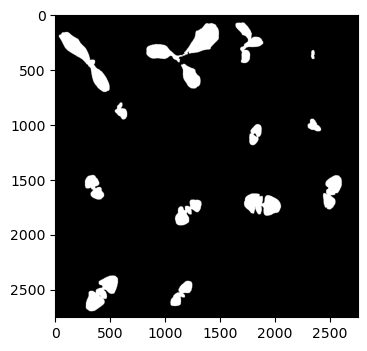

In [14]:
# Dilate so that you don't lose leaves (just in case)

# Inputs:
#    gray_img = input image
#    ksize    = integer, kernel size
#    i        = iterations, i.e. number of consecutive filtering passes
dilated = pcv.dilate(gray_img=fill_image, ksize=6, i=2)

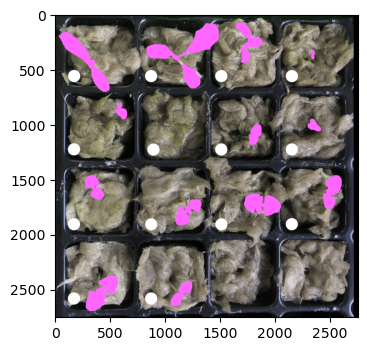

In [15]:
# Find objects (contours: black-white boundaries)

# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection
id_objects, obj_hierarchy = pcv.find_objects(img=img1, mask=dilated)

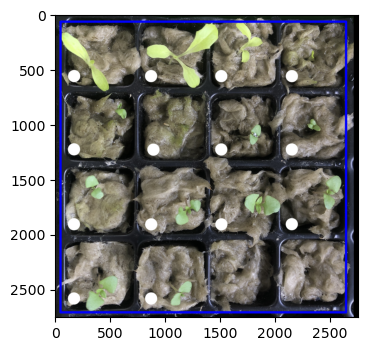

In [16]:
# Define region of interest (ROI)

# Inputs:
#    img   = An RGB or grayscale image to plot the ROI on.
#    x     = The x-coordinate of the upper left corner of the rectangle.
#    y     = The y-coordinate of the upper left corner of the rectangle.
#    h     = The width of the rectangle.
#    w     = The height of the rectangle.
#   roi_contour, roi_hierarchy = pcv.roi.rectangle(5, 90, 200, 390, img1) 
#                                                  |______________|
#                                            adjust these four values
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img1, x=50, y=60, h=2650, w=2600)

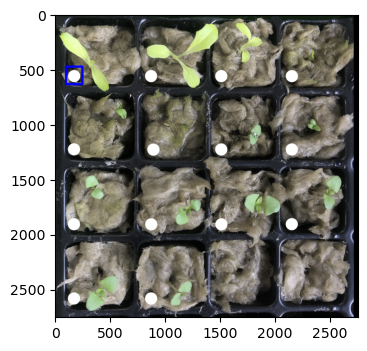

In [17]:
# (Optional): Get the size of the marker. First make a region of interest around one of 
# the toughspots. Then use `report_size_marker_area`. 
marker_contour, marker_hierarchy = pcv.roi.rectangle(img=img1, x=100, y=470, h=160, w=150)


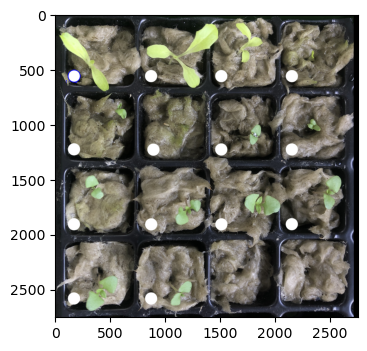

In [18]:
# Inputs:
#   img - RGB or grayscale image to plot the marker object on 
#   roi_contour = A region of interest contour 
#   roi_hierarchy = A region of interest contour heirarchy 
#   marker = 'define' (default) or 'detect', if 'define' then you set an area, if 'detect'
#            it means you want to detect within an area 
#   objcolor = Object color is 'dark' (default) or 'light', is the marker darker or lighter than 
#               the background?
#   thresh_channel = 'h', 's', 'v' for hue, saturation, or value. Default set to None. 
#   thresh = Binary threshold value (integer), default set to None 
#   label  = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

analysis_images = pcv.report_size_marker_area(img=img1, roi_contour=marker_contour, 
                                              roi_hierarchy=marker_hierarchy, marker='detect', 
                                              objcolor='light', thresh_channel='v', thresh=200)

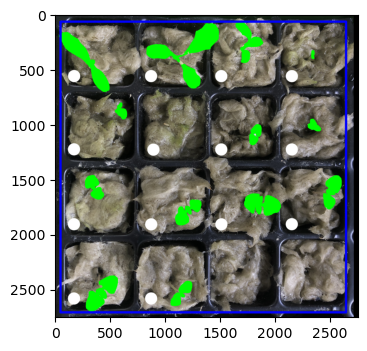

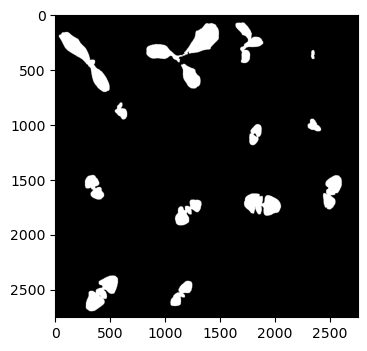

In [19]:
# Keep objects that overlap with the ROI

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)

roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img1, roi_contour=roi_contour, 
                                                                      roi_hierarchy=roi_hierarchy,
                                                                      object_contour=id_objects, 
                                                                      obj_hierarchy=obj_hierarchy, 
                                                                      roi_type='partial')

In [20]:
# Check if all of the plants fall completely within the bounds of an image 
# or if it touches the edge. Used for QC. 

# Inputs:
#   mask = Binary mask 
#   label = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

in_bounds = pcv.within_frame(mask=kept_mask)

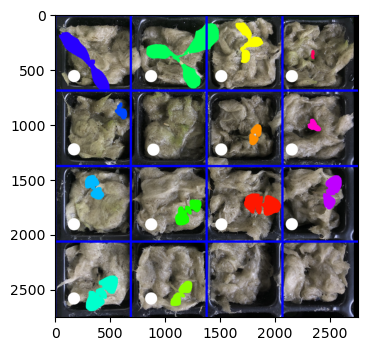

In [21]:
# This function take a image with multiple contours and
# clusters them based on user input of rows and columns

# Inputs:
#    img               = An RGB or grayscale image
#    roi_objects       = object contours in an image that are needed to be clustered.
#    roi_obj_hierarchy = object hierarchy
#    nrow              = number of rows to cluster (this should be the approximate  number of 
#                        desired rows in the entire image even if there isn't a literal row of plants)
#    ncol              = number of columns to cluster (this should be the approximate number of 
#                        desired columns in the entire image even if there isn't a literal row of plants)
#    show_grid         = if True then the grid is drawn on the image, default show_grid=False
clusters_i, contours, hierarchies = pcv.cluster_contours(img=img1, roi_objects=roi_objects, 
                                                         roi_obj_hierarchy=roi_obj_hierarchy, 
                                                         nrow=4, ncol=4, 
                                                         show_grid=True)

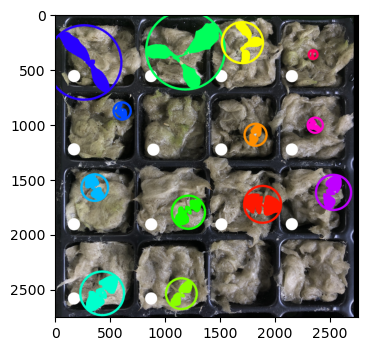

In [22]:
# Plot to visualize what pieces of plant got grouped together.

# Inputs:
#   img - RGB or grayscale image data for plotting
#   grouped_contour_indices - Indices for grouping contours
#   roi_objects - object contours in an image that are needed to be clustered.
#   roi_obj_hierarchy - object hierarchy
#   nrow - Optional, number of rows. If changed from default, grid gets plot. 
#   ncol - Optional, number of columns. If changed from default, grid gets plot. 
cluster_img = pcv.visualize.clustered_contours(img=img1, grouped_contour_indices=clusters_i, 
                                                roi_objects=contours,
                                                roi_obj_hierarchy=hierarchies)

In [23]:
#pcv.params.debug = "print"

# Inputs:
# mask             = Mask/binary image to segment into clusters.
# algorithm        = Algorithm to use for segregating different clusters.
#                    Currently supporting OPTICS and DBSCAN. (Default="DBSCAN")
# min_cluster_size = The minimum size a section of a mask must be (in pixels)
#                    before it can be considered its own cluster. (Default=5)
# max_distance     = The total distance between two pixels for them to be considered a part
#                    of the same cluster.  For the DBSCAN algorithm, value must be between
#                    0 and 1.  For OPTICS, the value is in pixels and depends on the size
#                    of your picture.  (Default=0)
#clust_img, clust_masks = pcv.spatial_clustering(mask=kept_mask, algorithm="DBSCAN", min_cluster_size=5, max_distance=0.1)



In [24]:
# The pcv.cluster_contours function uses another PlantCV function
# that returns a random list of RGB color values equally spaces
# across a rainbow color spectrum. This function can be useful 
# when a color palette is needed 

# Inputs:
#   num - An integer greater than or equal to 1. If num=1 then 
#         a random color is returned 
rand_colors = pcv.color_palette(num=5)
print(rand_colors)



[[255, 0, 40], [205, 255, 0], [0, 255, 139], [0, 23, 255], [255, 0, 191]]


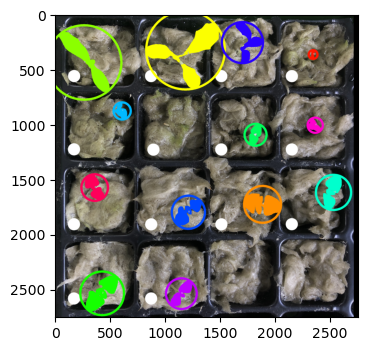

In [25]:
# Set the sequence of colors from the color_scale created by the 
# color_palette function to "sequential" or "random" order. 
# Default = "sequential". 
pcv.params.color_sequence = 'random'
cluster_img = pcv.visualize.clustered_contours(img=img1, grouped_contour_indices=clusters_i, 
                                                roi_objects=contours,
                                                roi_obj_hierarchy=hierarchies)

In [26]:
# This function takes clustered contours and splits them into multiple images,
# also does a check to make sure that the number of inputted filenames matches the number
# of clustered contours. If no filenames are given then the objects are just numbered

# Inputs:
#    img                     = ideally a masked RGB image.
#    grouped_contour_indexes = output of cluster_contours, indexes of clusters of contours
#    contours                = contours to cluster, output of cluster_contours
#    hierarchy               = object hierarchy
#    outdir                  = directory for output images
#    file                    = the name of the input image to use as a base name , output of filename from read_image function
#    filenames               = input txt file with list of filenames in order from top to bottom left to right (likely list of genotypes)

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "print"

out = args.outdir

# If you have a list of treatments, genotypes, etc. You would input a .txt file with them to help save
# the contours by names, add it to the options class and then add filenames=names to the 
# splitimg function below.  
output_path = pcv.cluster_contour_splitimg(rgb_img=img1, grouped_contour_indexes=clusters_i, contours=contours, 
                                           hierarchy=hierarchies, outdir=out, file=filename, filenames=None)

This function has been updated to include object hierarchy so object holes can be included


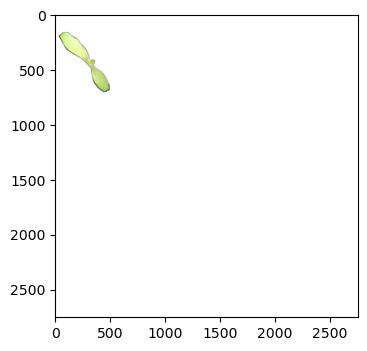

In [29]:
# Read in one of the isolated plant images 
pcv.params.debug = args.debug

single_plant, plant_path, plant_filename = pcv.readimage(filename='58_clusters.png')

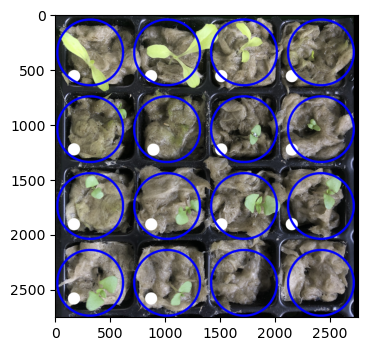

In [30]:
# Another option is to use multi_roi

# Create multiple ROIs on the same image:  
# Used to define multiple regions of interest in the same image. Users can either specify a
# starting coordinate (`coord`), number of rowsand columns, and spacing to create a grid of ROIs,
# or a custom list of coordinates that specify the centers of the ROIs. Providing a custom list 
# of coordinates (list of tuples) is useful for missing plants or any arrangement that isn't 
# a perfect grid. Returns lists of contours and hierarchies that can be used in downstream steps. 

#     Inputs
#     img            = Input image data.
#     coord          = Two-element tuple of the center of the top left object.
#     radius         = Radius of ROIs.
#     spacing        = Two-element tuple of the horizontal and vertical spacing between ROIs.
#     nrows          = Number of rows in ROI layout.
#     ncols          = Number of columns in ROI layout.

# Make a grid of ROIs 
rois1, roi_hierarchy1 = pcv.roi.multi(img=img1, coord=(320,340), radius=300, spacing=(700, 700), nrows=4, ncols=4)

# OR

# Specify a list of coordinates of desired ROIs 
#rois2, roi_hierarchy2 = pcv.roi.multi(img=img1, coord=[(25,120), (165,260), (310, 260)], radius=20)


In [31]:
len(rois1)

16

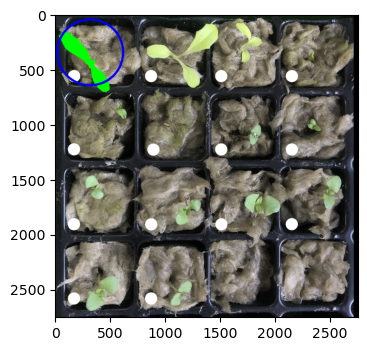

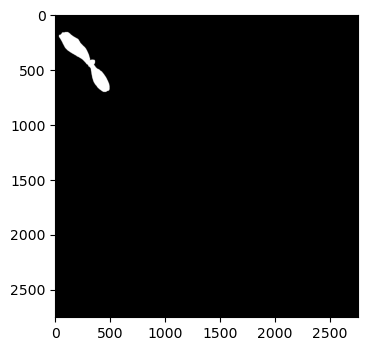

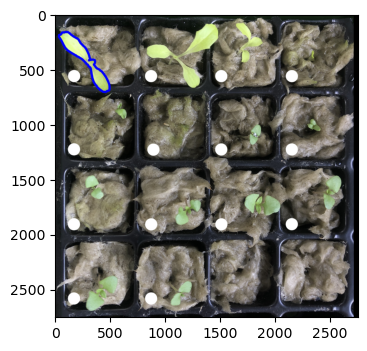

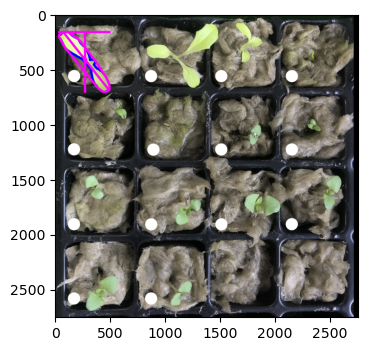

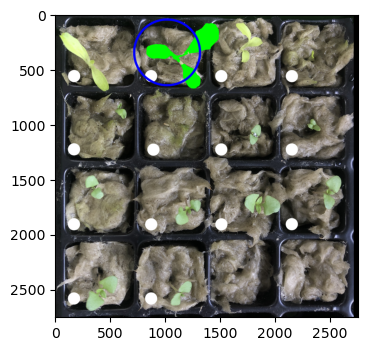

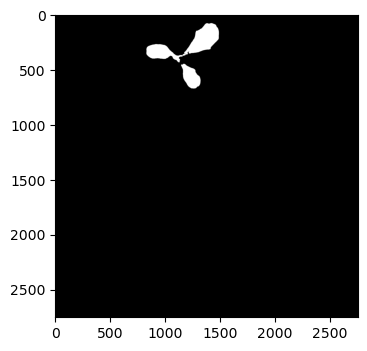

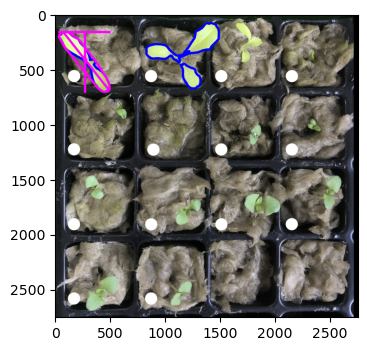

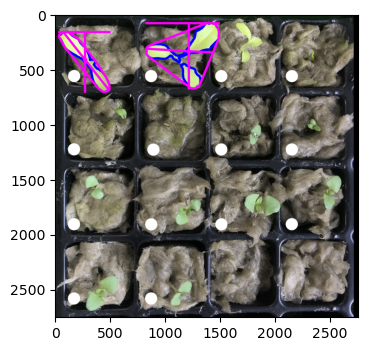

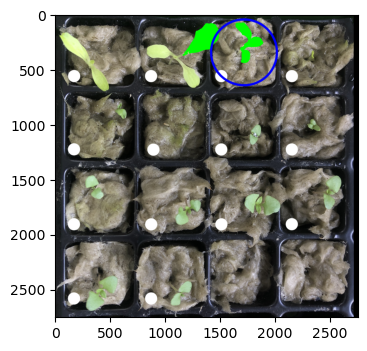

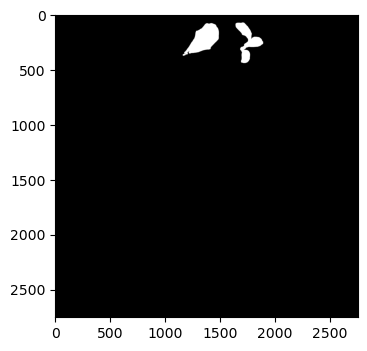

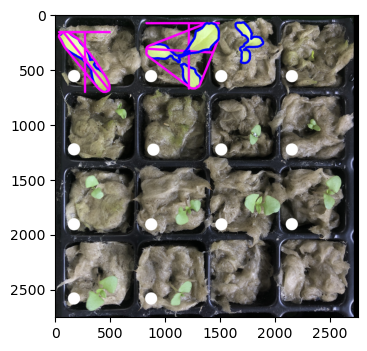

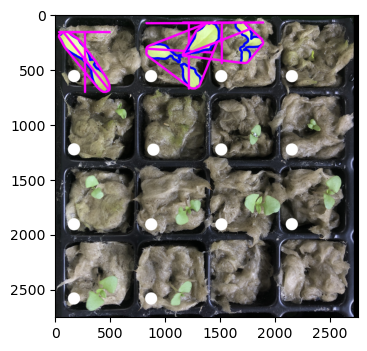

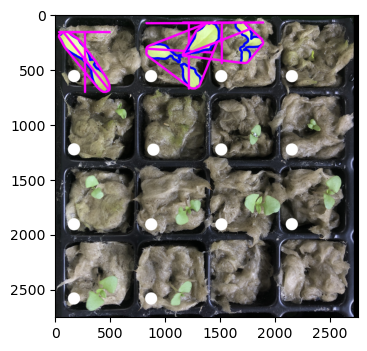

In [32]:
import numpy as np 

img_copy = np.copy(img1)

# Analyze each plant using the ROI's created by using the grid setup for pcv.roi.multi

for i in range(0, 3): # use len(rois1) for all 
    roi = rois1[i]
    hierarchy = roi_hierarchy1[i]
    # Filter objects by ROI 
    filtered_contours, filtered_hierarchy, filtered_mask, filtered_area = pcv.roi_objects(
        img=img1, roi_type="partial", roi_contour=roi, roi_hierarchy=hierarchy, object_contour=roi_objects, 
        obj_hierarchy=roi_obj_hierarchy)

    # Combine objects together in each plant     
    plant_contour, plant_mask = pcv.object_composition(img=img_copy, contours=filtered_contours, hierarchy=filtered_hierarchy)        

    # Analyze the shape of each plant 
    img_copy = pcv.analyze_object(img=img_copy, obj=plant_contour, mask=plant_mask) # Add argument label=str(i) if labels have been done

# Print out a text file with shape data for each plant in the image
pcv.print_results(args.result)

# Plot out the image with shape analysis on each plant in the image 
pcv.plot_image(img_copy)

